## AIHub 도로주행영상 데이터셋 라벨 YOLOv5 포맷으로 바꾸기

In [1]:
import os
import xml.etree.ElementTree as ET
import pandas as pd

aihub_label_paths = []

# 기존에 추출했던 aihub 이미지 경로들 리스트로 만들기
with open('/Users/Jinmi/Desktop/aihub_1000_list.txt', 'r') as f:
    for line in f:
        aihub_label_paths.append(line.strip())

In [2]:
# aihub -> kitti -> 숫자로 변환할 utility 함수 정의
def label_to_kitti(string):
    map_dict = {'Vehicle_Car' : 'Car', # 1
                'Vehicle_Unknown' : 'Car',
                'Pedestrian_Pedestrian' : 'Pedestrian', # 4
                'Pedestrian_Bicycle' : 'Cyclist',
                'Vehicle_Bus' : 'Tram', # 6
                }
    return map_dict[string]


def label_mapping(string):
    map_dict = {'Car' : 0,
                'Pedestrian' : 1,
                'Truck' : 2,
                'Cyclist' : 3,
                'Van' : 4,
                'Tram' : 5,
                'Misc' : 6,
                'Person_sitting' : 7,
                }
    return map_dict[string]

def int2str(num):
    map_dict = {0:'Car',
               1:'Pedestrian',
               2:'Truck',
               3:'Cyclist',
               4:'Van',
               5:'Tram',
               6:'Misc',
               7:'Person_sitting'}
    return map_dict[num]

In [3]:
label_path = aihub_label_paths[0]

### XML 파일에서 필요한 정보 추출하는 연습

In [4]:

# XML 파일 불러오기
tree = ET.parse(label_path)
root = tree.getroot()

# 이미지 경로 관련 데이터 추출
filename = root.find('filename').text
#     filename_int = sum([ord(x) for x in filename])
folder_name = root.find('folder').text

# 라벨 경로에서 이미지 경로 관련 데이터 추출
divisive_idx = label_path.find('/도심로')
part_front = label_path[:divisive_idx]
part_back = label_path[divisive_idx+5:]
part_back = '/'.join(part_back.split('/')[:4])

# 최종 이미지 경로
img_path = os.path.join(part_front, '도심로-1', part_back, folder_name, filename)

# 이미지 관련 데이터 추출
width = int(root.find('size').find('width').text)
height = int(root.find('size').find('height').text)

xmins = []
ymins = []
xmaxs = []
ymaxs = []
classes = []

for ob in root.findall('object'):
    bbox = ob.findall('bndbox')
    _class = ob.find('name').text
    if _class not in ['Vehicle_Car', 'Vehicle_Bus', 'Vehicle_Unknown', 'Pedestrian_Pedestrian', 'Pedestrian_Bicycle']:
        continue
    for box in bbox:
        xmin = int(box.find('xmin').text)
        ymin = int(box.find('ymin').text)
        xmax = int(box.find('xmax').text)
        ymax = int(box.find('ymax').text)
        xmins.append(xmin)
        ymins.append(ymin)
        xmaxs.append(xmax)
        ymaxs.append(ymax)
    class_txt = label_to_kitti(_class)
    class_int = label_mapping(class_txt)
    classes.append(class_int)
    
df = pd.DataFrame({'class':classes,
                   'xmin':xmins,
                   'ymin':ymins,
                   'xmax':xmaxs,
                   'ymax':ymaxs})

df['ob_width'] = df['xmax'] - df['xmin']
df['ob_height'] = df['ymax'] - df['ymin']
df['x_center'] = df['ob_width'] / 2 + df['xmin']
df['y_center'] = df['ob_height'] / 2 + df['ymin']
df['norm_x_center'] = df['x_center'] / width
df['norm_y_center'] = df['y_center'] / height
df['norm_ob_width'] = df['ob_width'] / width
df['norm_ob_height'] = df['ob_height'] / height

picked = df.loc[:, ['class', 'norm_x_center', 'norm_y_center', 'norm_ob_width', 'norm_ob_height']]

In [5]:
df

,class,xmin,ymin,xmax,ymax,ob_width,ob_height,x_center,y_center,norm_x_center,norm_y_center,norm_ob_width,norm_ob_height
0,3,1887,555,1919,630,32,75,1903.0,592.5,0.991146,0.548611,0.016667,0.069444
1,3,1756,553,1799,631,43,78,1777.5,592.0,0.925781,0.548148,0.022396,0.072222
2,1,1905,494,1919,577,14,83,1912.0,535.5,0.995833,0.495833,0.007292,0.076852
3,1,1607,511,1631,593,24,82,1619.0,552.0,0.843229,0.511111,0.012500,0.075926
4,1,1438,522,1459,561,21,39,1448.5,541.5,0.754427,0.501389,0.010937,0.036111
5,1,0,561,11,609,11,48,5.5,585.0,0.002865,0.541667,0.005729,0.044444
6,0,493,459,763,690,270,231,628.0,574.5,0.327083,0.531944,0.140625,0.213889
7,5,365,427,658,644,293,217,511.5,535.5,0.266406,0.495833,0.152604,0.200926
8,5,724,485,828,594,104,109,776.0,539.5,0.404167,0.499537,0.054167,0.100926
9,5,817,506,850,533,33,27,833.5,519.5,0.434115,0.481019,0.017188,0.025000


In [6]:
# 여러 dtype이 섞인 판다스 데이터프레임을 넘파이 어레이로 변환 시 어떻게 되는지 확인
df.to_numpy()[0]

array([3.00000000e+00, 1.88700000e+03, 5.55000000e+02, 1.91900000e+03,
       6.30000000e+02, 3.20000000e+01, 7.50000000e+01, 1.90300000e+03,
       5.92500000e+02, 9.91145833e-01, 5.48611111e-01, 1.66666667e-02,
       6.94444444e-02])

In [7]:
df['norm_ob_width'].dtype

dtype('float64')

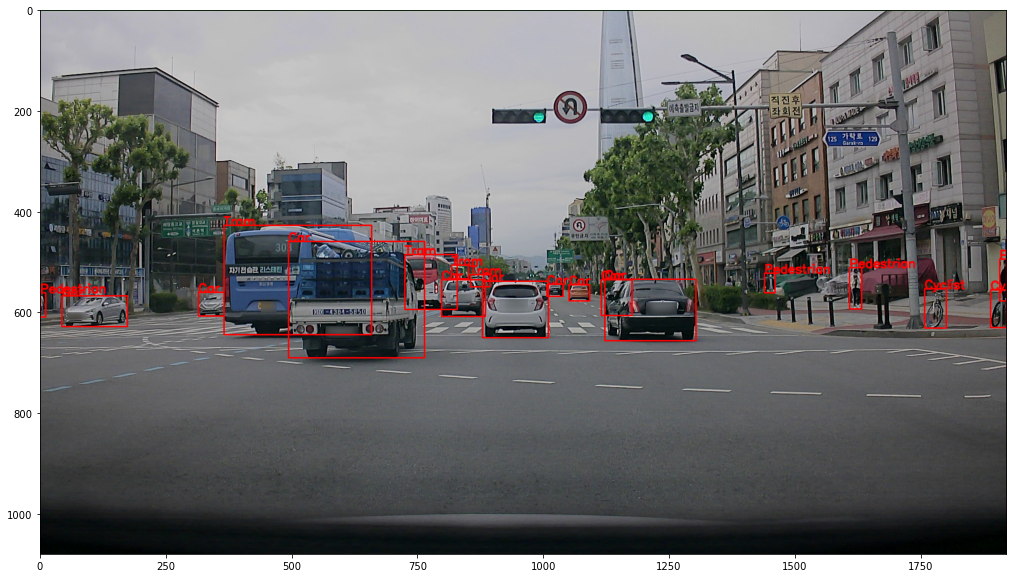

In [8]:
# 데이터가 맞게 추출 됐는지 이미지에 bounding box 그려서 확인
import cv2
import matplotlib.pyplot as plt

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img_copy = img.copy()

font = cv2.FONT_HERSHEY_SIMPLEX
fontScale = 0.8
color = (255, 0, 0)
thickness = 2

for row in df.iloc[:, :5].to_numpy():
    cv2.rectangle(img_copy, (row[1], row[2]), (row[3], row[4]), color, thickness)
    cv2.putText(img_copy, int2str(row[0]), (row[1], row[2]), font, fontScale, color, thickness, cv2.LINE_AA)


plt.figure(figsize=(20, 10))
plt.imshow(img_copy)

### YOLOv5 라벨로 변환 및 해당 이미지 옮기기

In [9]:
import shutil

In [12]:
%%time

# 이미지 및 라벨을 저장할 경로 설정
label_dir = '/Users/Jinmi/Desktop/aihub_yolov5_1000_labels'
image_dir = '/Users/Jinmi/Desktop/aihub_yolov5_1000_images'
if not os.path.exists(label_dir):
    os.mkdir(label_dir)
if not os.path.exists(image_dir):
    os.mkdir(image_dir)

for label_path in aihub_label_paths:
    # XML 파일 불러오기
    tree = ET.parse(label_path)
    root = tree.getroot()

    # 이미지 경로 관련 데이터 추출
    filename = root.find('filename').text
    #     filename_int = sum([ord(x) for x in filename])
    folder_name = root.find('folder').text

    # 라벨 경로에서 이미지 경로 관련 데이터 추출
    divisive_idx = label_path.find('/도심로')
    part_front = label_path[:divisive_idx]
    part_back = label_path[divisive_idx+5:]
    part_back = '/'.join(part_back.split('/')[:4])

    # 최종 이미지 경로
    img_path = os.path.join(part_front, '도심로-1', part_back, folder_name, filename)

    # 이미지 관련 데이터 추출
    width = int(root.find('size').find('width').text)
    height = int(root.find('size').find('height').text)

    xmins = []
    ymins = []
    xmaxs = []
    ymaxs = []
    classes = []

    for ob in root.findall('object'):
        bbox = ob.findall('bndbox')
        _class = ob.find('name').text
        if _class not in ['Vehicle_Car', 'Vehicle_Bus', 'Vehicle_Unknown', 'Pedestrian_Pedestrian', 'Pedestrian_Bicycle']:
            continue
        for box in bbox:
            xmin = int(box.find('xmin').text)
            ymin = int(box.find('ymin').text)
            xmax = int(box.find('xmax').text)
            ymax = int(box.find('ymax').text)
            xmins.append(xmin)
            ymins.append(ymin)
            xmaxs.append(xmax)
            ymaxs.append(ymax)
        class_txt = label_to_kitti(_class)
        class_int = label_mapping(class_txt)
        classes.append(class_int)

    df = pd.DataFrame({'class':classes,
                       'xmin':xmins,
                       'ymin':ymins,
                       'xmax':xmaxs,
                       'ymax':ymaxs})

    df['ob_width'] = df['xmax'] - df['xmin']
    df['ob_height'] = df['ymax'] - df['ymin']
    df['x_center'] = df['ob_width'] / 2 + df['xmin']
    df['y_center'] = df['ob_height'] / 2 + df['ymin']
    df['norm_x_center'] = df['x_center'] / width
    df['norm_y_center'] = df['y_center'] / height
    df['norm_ob_width'] = df['ob_width'] / width
    df['norm_ob_height'] = df['ob_height'] / height

    picked = df.loc[:, ['class', 'norm_x_center', 'norm_y_center', 'norm_ob_width', 'norm_ob_height']]
    
    # 라벨 및 이미지 저장할 경로 설정
    txt_to = filename[:-4] + '.txt'
    label_to_path = os.path.join(label_dir, txt_to)
    image_to_path = os.path.join(image_dir, filename)

    picked.to_csv(label_to_path, sep=' ', index=False, header=False)
    shutil.copy(img_path, image_to_path)

CPU times: user 8.85 s, sys: 1.77 s, total: 10.6 s
Wall time: 17.8 s


In [13]:
print(len(os.listdir(label_dir)))
print(len(os.listdir(image_dir)))

1000
1000
